<a href="https://colab.research.google.com/github/jonatangraversen01-lab/AI-in-Transport/blob/main/Project_feature_engineering_with_existing_ITS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd

url = "https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/ProjectAssignmentData/Dataset-PT.csv"
df = pd.read_csv(url, skiprows=1)

df.head(15)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,previous_bus_delay,previous_trip_travel_time,traffic_condition,recurrent_delay,weather,temperature,day_of_week,time_of_day,factor(weather)Light_Rain,factor(weather)Light_Snow,factor(weather)Normal,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,160,216,168.666667,161.25,Light Snow,Normal,weekend,OP,0,1,0,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,198,47,46.333333,36.50,Light Snow,Normal,weekend,OP,0,1,0,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,189,32,36.666667,34.00,Light Snow,Normal,weekend,OP,0,1,0,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,200,89,88.000000,87.00,Light Snow,Normal,weekend,OP,0,1,0,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,256,123,102.000000,88.75,Light Snow,Normal,weekend,OP,0,1,0,0,0,0,0,1,0,1,0,0,1
5,20220108,4,41344,6,260,13,105,38,242,100,255,37,35.000000,37.25,Light Snow,Normal,weekend,OP,0,1,0,0,0,0,0,1,0,1,0,0,1
6,20220108,4,41344,7,278,12,43,79,260,100,238,62,73.000000,69.25,Light Snow,Normal,weekend,OP,0,1,0,0,0,0,0,1,0,1,0,0,1
7,20220108,4,41344,8,272,8,85,97,278,100,213,72,83.333333,72.50,Light Snow,Normal,weekend,OP,0,1,0,0,0,0,0,1,0,1,0,0,1
8,20220108,4,41344,9,292,24,83,47,272,100,210,30,37.666667,33.50,Light Snow,Normal,weekend,OP,0,1,0,0,0,0,0,1,0,1,0,0,1
9,20220108,4,41344,10,351,9,43,85,292,100,240,115,121.000000,105.25,Light Snow,Normal,weekend,OP,0,1,0,0,0,0,0,1,0,1,0,0,1


In [30]:
trip_df = df[
    (df["route_id"] == 4) &
    (df["bus_id"] == 41344) &
    (df["Calendar_date"] == 20220108)
].sort_values("stop_sequence")

In [31]:
pd.set_option("display.max_columns", None)
print(trip_df.head(10))

     Calendar_date  route_id  bus_id  stop_sequence  arrival_delay  \
0         20220108         4   41344              1            151   
162       20220108         4   41344              1            106   
297       20220108         4   41344              1              3   
163       20220108         4   41344              2            116   
298       20220108         4   41344              2             37   
1         20220108         4   41344              2            185   
2         20220108         4   41344              3            186   
164       20220108         4   41344              3             99   
299       20220108         4   41344              3             53   
300       20220108         4   41344              4             43   

     dwell_time  travel_time_for_previous_section  scheduled_travel_time  \
0             0                                 0                    120   
162           0                                 0                    120   
2

In [32]:
df = df.drop(['upstream_stop_delay', "previous_bus_delay", "previous_trip_travel_time", "travel_time_for_previous_section", "Calendar_date", "route_id", "bus_id", "factor(weather)Snow"], axis=1)

In [33]:

#df['rain_x_traffic'] = df['factor(weather)Rain'] * df['traffic_condition']
df['peak_x_dwell'] = df['factor(time_of_day)Morning_peak'] * df['dwell_time']
df['rain_and_cold'] = df['factor(weather)Rain'] * df['factor(temperature)Cold']
#df['snow_and_peak'] = df['factor(weather)Snow'] * df['factor(time_of_day)Morning_peak']

In [34]:
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()
corr_matrix['arrival_delay'].sort_values(ascending=False)

,arrival_delay
arrival_delay,1.000000
origin_delay,0.716324
factor(day_of_week)weekend,0.190783
factor(time_of_day)Off-peak,0.138109
stop_sequence,0.092616
dwell_time,0.089433
factor(weather)Normal,0.022642
factor(temperature)Normal,0.022444
factor(weather)Rain,0.010833
factor(weather)Light_Snow,-0.012642


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Features (X) and target (y)
X = df.drop(columns=['arrival_delay'])
y = df['arrival_delay']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Drop raw string categorical columns
cols_to_drop = ['weather', 'temperature', 'day_of_week', 'time_of_day']
X_train = X_train.drop(columns=cols_to_drop)
X_test  = X_test.drop(columns=cols_to_drop)

In [36]:
import xgboost as xgb

model = xgb.XGBRegressor()
#https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
param_dist = {
    'n_estimators': [200, 300, 400],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1, 0.15, 0.2]
}

random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10,
                                   scoring='r2', cv=3, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.15, 0.2],
                                        'max_depth': [5, 6, 7],
                                        'n_estimators': [200, 300, 400]},
                   scoring='r2', verbose=1)

In [38]:
best_params = random_search.best_params_

print("Best Parameters:", best_params)
print("Best Score:", random_search.best_score_)

Best Parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.15}
Best Score: 0.6135072310765585


In [39]:
import xgboost as xgb

best_xgb = xgb.XGBRegressor(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    random_state=42
)

best_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.15, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

n = len(y_test)

# Number of predictors (features in your model)
p = X.shape[1]   # if X is your features dataframe/array

# Step 2: Calculate Adjusted R²
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Adjusted R²: {adj_r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Adjusted R²: 0.6225354598112651
Mean Absolute Error: 83.33466339111328
Mean Squared Error: 14110.90234375
R-squared: 0.622618556022644


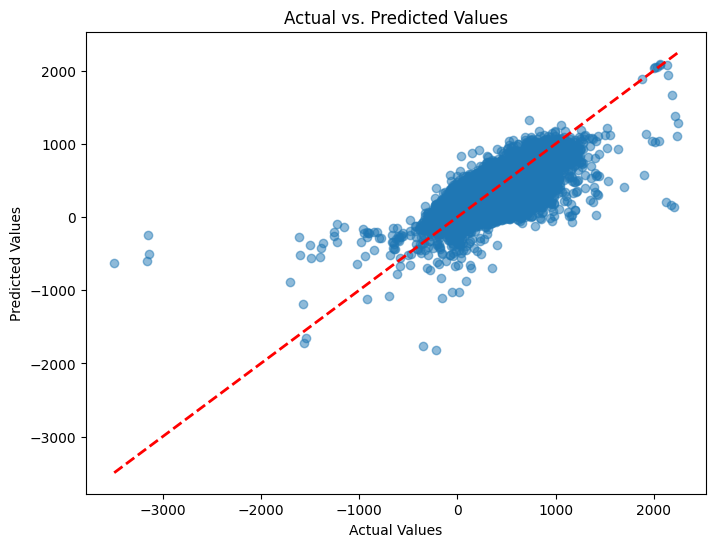

In [41]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
# y_test contains the actual target values for the test dataset
# y_pred contains the predicted values for the test dataset

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

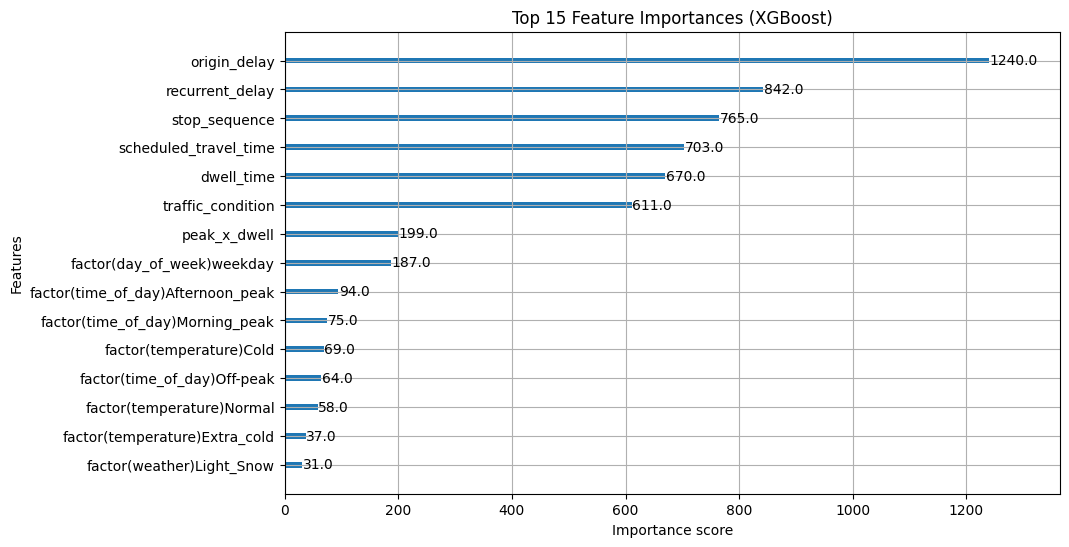

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, max_num_features=15, ax=ax)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize model with predetermined parameters
tree_reg = DecisionTreeRegressor(
    max_depth=11,
    min_samples_split=16,
    min_samples_leaf=8,
    random_state=42,
    criterion='squared_error',
    max_features=None
)

# Fit model
tree_reg.fit(X_train, y_train)

y_pred = tree_reg.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:}")
print(f"Mean Absolute Error: {mae:}")
print(f"R-squared: {r2:}")

Mean Squared Error: 15129.656017675547
Mean Absolute Error: 89.10692806073267
R-squared: 0.5953730652421495


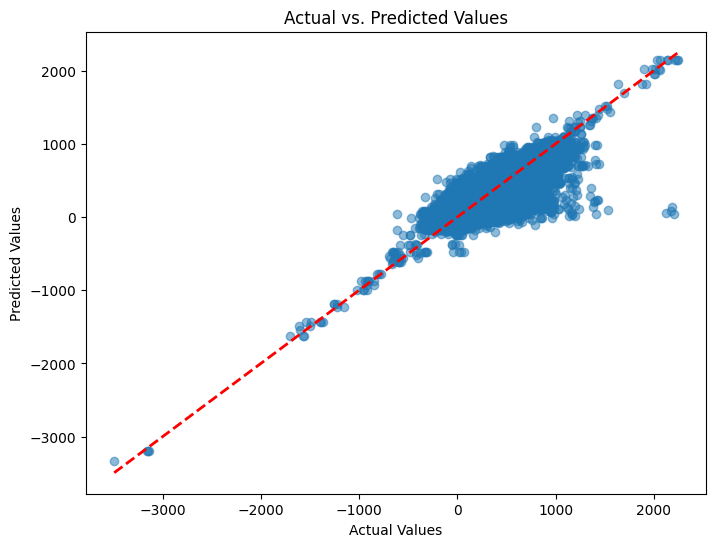

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

In [45]:
new_data = pd.DataFrame([{
    'stop_sequence': 2,
    'dwell_time': 23,
    'scheduled_travel_time': 60,
    'origin_delay': 17,
    'traffic_condition': 47,
    'recurrent_delay': 42.3,
    'factor(weather)Light_Rain': 0,
    'factor(weather)Light_Snow': 1,
    'factor(weather)Normal': 0,
    'factor(weather)Rain': 0,
    'factor(weather)Snow': 0,
    'factor(temperature)Cold': 0,
    'factor(temperature)Extra_cold': 0,
    'factor(temperature)Normal': 1,
    'factor(day_of_week)weekday': 0,
    'factor(day_of_week)weekend': 1,
    'factor(time_of_day)Afternoon_peak': 0,
    'factor(time_of_day)Morning_peak': 0,
    'factor(time_of_day)Off-peak': 1
}])

In [46]:
new_data = new_data.reindex(columns=X_train.columns, fill_value=0)

In [47]:
predicted_delay = best_xgb.predict(new_data)
print("Predicted arrival delay (seconds):", predicted_delay[0])

Predicted arrival delay (seconds): 55.78826


In [48]:
# Copy the current stop row
next_stop = new_data.copy()

# Increment the stop sequence
next_stop['stop_sequence'] = next_stop['stop_sequence'] + 1

# Make sure columns match your training data
predicted_next_delay = model.predict(next_stop[X_train.columns].values)[0]

print("Predicted arrival delay at the next stop:", predicted_next_delay)

Predicted arrival delay at the next stop: 49.701748


In [49]:
results = pd.DataFrame({
    'stop_sequence': [new_data['stop_sequence'].values[0], next_stop['stop_sequence'].values[0]],
    'predicted_delay': [model.predict(new_data[X_train.columns].values)[0], predicted_next_delay]
})

print(results)

   stop_sequence  predicted_delay
0              2        49.701748
1              3        49.701748


In [50]:
import pandas as pd

def predict_next_stops(model, start_row, feature_columns, n_stops=5):
    """
    Predict arrival delays for the next n_stops using the given model.

    Parameters:
        model: trained XGBoost model
        start_row: DataFrame with one row (the current stop's feature values)
        feature_columns: list of features used in training (X_train.columns)
        n_stops: number of stops ahead to predict

    Returns:
        DataFrame with stop_sequence and predicted delays
    """
    results = []

    # Start with the current stop
    current_stop = start_row.copy()

    for i in range(n_stops):
        # Predict current stop's delay
        predicted_delay = model.predict(current_stop[feature_columns].values)[0]

        # Save result
        results.append({
            "stop_sequence": current_stop["stop_sequence"].values[0],
            "predicted_delay": predicted_delay
        })

        # Prepare next stop
        next_stop = current_stop.copy()
        next_stop["stop_sequence"] = current_stop["stop_sequence"] + 1

        # If you had previous delay info, you could use it here:
        # next_stop["origin_delay"] = predicted_delay
        # next_stop["upstream_stop_delay"] = predicted_delay

        # Keep other features constant (you can modify this part later if you have dynamics)
        current_stop = next_stop.copy()

    return pd.DataFrame(results)

In [51]:
predicted_trip = predict_next_stops(
    model=model,
    start_row=new_data,
    feature_columns=X_train.columns,
    n_stops=10  # predict next 5 stops
)

print(predicted_trip)

   stop_sequence  predicted_delay
0              2        49.701748
1              3        49.701748
2              4        60.824051
3              5        54.249973
4              6        70.683006
5              7        74.841927
6              8        79.577499
7              9        70.827827
8             10       100.065117
9             11       107.887810
